## 🤖 EX_08 뉴스 요약봇 만들기 🤖

### 목표: seq2seq 모델로 Abstractive summarization 방식의 텍스트 요약기 만들기

#### lubric

1. Abstractive 모델 구성을 위한 텍스트 전처리(분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩) 과정이 빠짐없이 체계적으로 진행되었다.
2. 텍스트 요약 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
3. Extractive 요약과 Abstractive 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

#### 🚩keyword

✔ 1) Extractive, Abstractive summarization

- 추출적 요약(Extractive Summarization): 단어 그대로 원문에서 문장들을 추출해서 요약하는 방식. 10개의 문장으로 구성된 텍스트가 있다면, 그중 핵심적인 문장 3개를 꺼내와서 3개의 문장으로 구성된 요약문을 만드는 식. 그런데 꺼내온 3개의 문장이 원문에서 중요한 문장일 수는 있어도, 결과로 나온 문장들 간의 호응이 자연스럽지 않을 수 있다. 딥 러닝보다는 주로 전통적인 머신 러닝 방식에 속하는 텍스트 랭크(TextRank)와 같은 알고리즘을 사용해서 이 방법을 사용

- 추상적 요약(Abstractive Summarization): 원문으로부터 내용이 요약된 새로운 문장을 생성해내는 방식. 여기서 새로운 문장이라는 것은 결과로 나온 문장이 원문에 원래 없던 문장일 수도 있다는 것을 의미. 자연어 처리 분야 중 자연어 생성(Natural Language Generation, NLG)의 영역. 반면, 추출적 요약은 원문을 구성하는 문장 중 어느 것이 요약문에 들어갈 핵심문장인지를 판별한다는 점에서 문장 분류(Text Classification) 문제로 볼 수도 있다.

✔ 2) seq2seq, Attention Mechanism
- seq2seq: 두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성해 내는 자연어 생성 모델

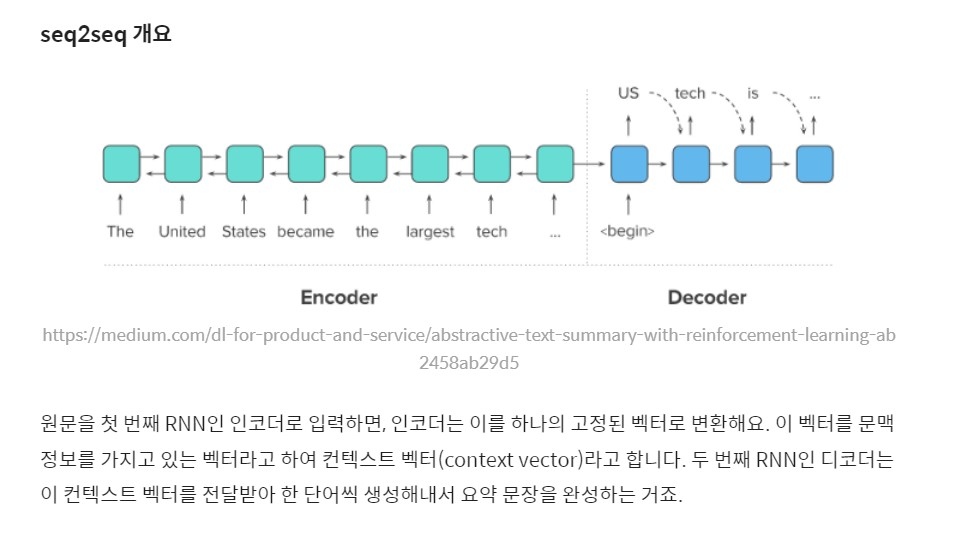

In [2]:
from IPython.display import Image

Image("화면 캡처 2022-02-07 102307.jpg")

✔ 3) 어텐션 메커니즘(Attention Mechanism): 인코더의 모든 step의 hidden state의 정보가 컨텍스트 벡터에 전부 반영되도록 하는 것. 하지만 인코더의 모든 hidden state가 동일한 비중으로 반영되는 것이 아니라, 디코더의 현재 time step의 예측에 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산되는 방식

✔ 4) EarlyStopping(조기종료) : 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 patience=2(2회) 관측되면 학습을 멈추도록 설정

In [62]:
# NLTK(Natural Language Toolkit): 영어 기호, 통계, 자연어 처리를 위한 라이브러리
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

=3


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [64]:
data.sample(10)

,headlines,text
84055,"Those celebrating PakÃ¢ÂÂs win, go there: Mi...",National Commission for Minorities Chairman Ga...
20355,Bombay HC warns man claiming possession of cou...,Bombay High Court has warned a man against fil...
85602,Pak-born London terrorist was trying for a job...,"Pakistan-born London terrorist Khuram Butt, wh..."
86099,"Uber accused of sending couple mouldy, half-ea...",A Toronto couple has accused Uber's delivery s...
39607,Instagram may let users post hour-long videos,Facebook's photo-sharing app Instagram may let...
9406,I value freedom we have because of Rani Laxmib...,"Kangana Ranaut, who will be seen as Rani Laxmi..."
92189,Startup's solar & wind powered drone can trave...,US-based startup Ocean Aero has created a new ...
29808,SoftBank confirms selling entire Flipkart stak...,Japanese conglomerate SoftBank has confirmed i...
75392,"Allah is the owner of mosques, not Maulana: As...",AIMIM chief Asaduddin Owaisi has said that mos...
46720,Amateur astronomer first to capture first ligh...,"For the first time, the initial burst of light..."


- Text 열의 내용을 요약한 것이 headlines열
- 인공 신경망을 통해 Text 시퀀스를 입력받으면, headlines 시퀀스를 예측하도록 인공 신경망을 훈련

### 데이터 전처리 (1) 데이터 정리

In [65]:
# 데이터의 중복 샘플 유무 확인

print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [66]:
# text 자체가 중복이 된 경우는 중복 샘플이므로 제거

# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [67]:
# 데이터프레임에 Null 값이 있는지 확인

print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [68]:
# Null을 제거할 때는 dropna() 함수

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [69]:
# 텍스트 정규화(text normalization) 

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [70]:
# 불용어 제거 (1)

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [71]:
# 불용어 제거 (2)

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [72]:
# 불용어 제거 (3)

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [73]:
# Text의 경우에는 불용어를 제거하고, headlines의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행
# 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력

clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [30]:
# headlines에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False

clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [74]:
# 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우 샘플 자체가 빈 값을 가지게 된다.
# 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체
# 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장

data['Text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [75]:
# .isnull().sum()을 사용해서 Null 값이 생겼는지 확인

data.isnull().sum()

headlines    0
text         0
Text         0
dtype: int64

In [76]:
# 원래는 단어가 있었는데, 정제 과정에서 모든 단어가 제거되어 빈 이 샘플들은 모두 제거

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 데이터 전처리 (2) 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


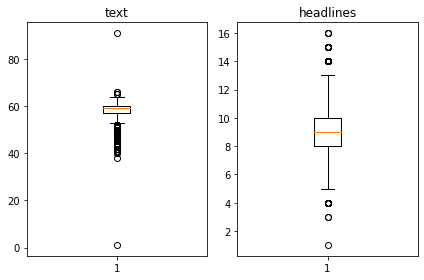

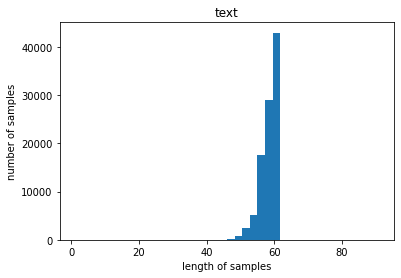

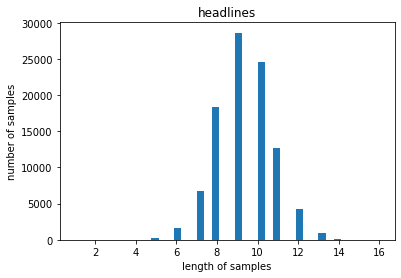

In [77]:
# 샘플의 최대 길이 정하기

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [78]:
# Text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정하기
# 최대한 많이 포함하고 싶어서 평균을 위의 값인 text 60, headlines 12으로 설정

text_max_len = 60
headlines_max_len = 12
print('=3')

=3


In [79]:
# 각각 60과 12로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [80]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.997448149654331
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [81]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96938


seq2seq 훈련을 위해서 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가. 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 명명하고 앞, 뒤로 추가. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target

In [82]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,Text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [83]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [84]:
# 훈련 데이터와 테스트 데이터를 분리 (1)
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[65939 66976 26635 ... 79983 83583 56060]


In [85]:
# (2)
# 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플 완성

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [86]:
# (3) 
# 훈련 데이터와 테스트 데이터로 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19387


In [87]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77551
훈련 레이블의 개수 : 77551
테스트 데이터의 개수 : 19387
테스트 레이블의 개수 : 19387


### 데이터 전처리 (3) 정수 인코딩

**단어 집합(vocabulary) 만들기 및 정수 인코딩**

단어 집합(vocabulary) 만들기: 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꿔주는 즉 각 단어에 고유한 정수를 맵핑하는 작업

단어집합 만들기 > 빈도수 낮은 단어들 훈련데이터에서 제외 > 희귀 단어 집합 크기 제외 > 정수시퀀스로 변환

In [88]:
# 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들기
# Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [89]:
# 이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여됨
# 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장
# 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행 목표
# 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
# src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있으니 활용

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 90685
등장 빈도가 6번 이하인 희귀 단어의 수: 66068
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24617
단어 집합에서 희귀 단어의 비율: 72.85438606164195
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7526844770555168


In [90]:
# 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거 목표
# 희귀 단어의 비율은 72%지만 등장 빈도 비율이 2.8%정도 밖에 안되니 제외시키고 단어 집합의 크기를 재설정 해봤다
# 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다

src_vocab = 24000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 24,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [91]:
# texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행
# 현재 단어 집합의 크기를 24,000으로 제한했으니까 이제 24,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1, 1816, 49, 8, 1784, 11, 1, 1000, 991, 1628, 53, 403, 449, 1764, 16008, 2, 2477, 17, 3400, 12, 482, 2, 61, 190, 2, 1, 1000, 29, 2013, 16008, 19, 24, 921, 4874, 8983, 2471, 140, 1, 1394, 5, 10733, 12, 2163, 2, 25, 482, 2, 17, 22813, 1, 49, 33], [10126, 959, 437, 100, 7, 113, 2104, 17, 1765, 707, 2, 689, 4288, 5557, 18, 384, 6189, 1655, 5, 1, 575, 1538, 5, 6316, 6, 692, 7, 1, 2925, 461, 5557, 8, 98, 11, 1, 6316, 237, 12, 3, 186, 5, 6524, 3536, 2998, 2, 10993, 640, 289, 47, 61], [22, 269, 132, 671, 387, 45, 1073, 46, 251, 324, 1010, 1940, 5874, 170, 3, 2703, 22, 3, 12067, 2679, 1272, 4, 1460, 7, 119, 1, 435, 1106, 15, 24, 2971, 2044, 7516, 1, 690, 5, 1, 2679, 1272, 16, 1601, 75, 149, 251, 1190, 323, 1, 285, 2574, 13, 611, 2, 1690, 63, 19, 206, 1, 1092]]


In [92]:
# headlines 데이터에 대해서도 동일한 작업을 수행

# 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [93]:
# 이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여 확인: tar_tokenizer.word_index에 저장
# tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 
# 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29951
등장 빈도가 5번 이하인 희귀 단어의 수: 19627
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10324
단어 집합에서 희귀 단어의 비율: 65.53036626489933
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.72463334142748


In [94]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 161, 450, 5373, 190, 3, 6428, 3058], [1, 3858, 83, 813, 10, 614, 7, 2547], [1, 123, 4, 1059, 12, 5152, 1340, 4, 857], [1, 1521, 5, 230, 1124, 824, 394, 3, 77, 223, 109], [1, 146, 89, 15, 1816, 2448, 14, 523]]
target
decoder  [[161, 450, 5373, 190, 3, 6428, 3058, 2], [3858, 83, 813, 10, 614, 7, 2547, 2], [123, 4, 1059, 12, 5152, 1340, 4, 857, 2], [1521, 5, 230, 1124, 824, 394, 3, 77, 223, 109, 2], [146, 89, 15, 1816, 2448, 14, 523, 2]]


정수 인코딩 끝 > 확인작업


전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있고 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 두드러졌을 것.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아오는데, 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않는다. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 것임(길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까)

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장 후 이 모두 삭제할 거예요.

In [95]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77551
훈련 레이블의 개수 : 77551
테스트 데이터의 개수 : 19387
테스트 레이블의 개수 : 19387


In [96]:
# 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업
# 아까 정해두었던 최대 길이로 패딩 시작 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰주기

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


### 모델 설계(어텐션 메커니즘 (Attention Mechanism))

### start

1. seq2seq를 사용합니다.
2. RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.
3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.
4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.
5. seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.
6. 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.

In [97]:
# 함수형 API를 이용해서 인코더를 설계

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [98]:
# 디코더 설계

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [99]:
# 디코더의 출력층을 설계

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 128)      3072000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 60, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [100]:
# 지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq에요. 
# 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있어요! 바로 어텐션 메커니즘
# Bahdanau 스타일의 어텐션
# 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해 봅시다.

from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 128)      3072000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 60, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련

In [101]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) #patience가 가장중요
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
303/303 [==============================] - 252s 805ms/step - loss: 5.6478 - val_loss: 5.2531
Epoch 2/50
303/303 [==============================] - 239s 789ms/step - loss: 5.1110 - val_loss: 4.8712
Epoch 3/50
303/303 [==============================] - 236s 778ms/step - loss: 4.7575 - val_loss: 4.6143
Epoch 4/50
303/303 [==============================] - 237s 782ms/step - loss: 4.4885 - val_loss: 4.4010
Epoch 5/50
303/303 [==============================] - 237s 783ms/step - loss: 4.2835 - val_loss: 4.2628
Epoch 6/50
303/303 [==============================] - 235s 777ms/step - loss: 4.1132 - val_loss: 4.1395
Epoch 7/50
303/303 [==============================] - 234s 772ms/step - loss: 3.9666 - val_loss: 4.0396
Epoch 8/50
303/303 [==============================] - 237s 783ms/step - loss: 3.8378 - val_loss: 3.9602
Epoch 9/50
303/303 [==============================] - 237s 783ms/step - loss: 3.7235 - val_loss: 3.9022
Epoch 10/50
303/303 [==============================] - 242s 797m

In [ ]:
start 15:15 ~ finish 17:12

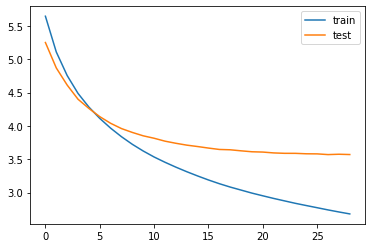

In [102]:
# 이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [103]:
# 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 
# 필요한 3개의 사전을 아래와 같이 미리 준비

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


eq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [104]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [105]:
# 어텐션 메커니즘을 사용하는 출력층을 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [106]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


### 모델 테스트(2)(tar_vocab: 24000, 10000 )

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인해야함. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들기. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들어야함.

In [107]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [108]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : wilful defaulter vijay mallya who is facing an extradition hearing at westminster magistrates court on tuesday said i've nothing to say i deny all allegations stating that he has not done anything illegal and not any court mallya said he has enough evidence to prove his case mallya fled india last year owing over ã¢ââ¹9 000 crore to banks 
실제 요약 : have nothing to say deny all allegations vijay mallya 
예측 요약 :  mallya cannot be made by mallya says director


원문 : us multinational corporation walmart announced on friday that it has acquired men's clothing brand walmart is paying 310 million nearly ã¢ââ¹2 000 crore in cash for the deal slightly more than 300 million ã¢ââ¹1 930 crore valuation when it raised 55 million in 2014 started by selling online but has since expanded and opened several brick and mortar 
실제 요약 : walmart acquires men wear company for crore 
예측 요약 :  walmart invests crore in us


원문 : as per reports sunil grover rejected kapil sharma's new show 'family time wi

예측 요약 :  no one of the world no alliance with bjp chairman


원문 : kamal haasan while addressing rumours that his daughter has changed her religion tweeted he loves her even if she has done so replying to this wrote s till an although i agree with buddhism as it is a way of life and in an individual's way of life earlier there were reports that had converted to buddhism 
실제 요약 : love you even if you have changed religion haasan to daughter 
예측 요약 :  love to love to see if it is love vidya


원문 : largest commercial vehicle maker ashok shares fell about 10 5 on wednesday after ceo and md vinod dasari announced his resignation dasari had joined the group company as chief operating officer fourteen years ago and took over as the md in 2011 the company on tuesday posted a lower than expected 37 5 rise in second quarter profit at crore 
실제 요약 : ashok stock falls after ceo vinod quits 
예측 요약 :  veteran ceo resigns after years


원문 : actor who played james bond in four films revealed he was fru

예측 요약 :  my father is my daughter will be salman khan


원문 : punjab national bank pnb maestro debit card holders will face card blockage if they fail to replace it with a more secure chip based card by july 31 new replacement cards will be provided free of cost to the customers earlier rbi had directed all banks to migrate to chip based cards by december 31 2018 
실제 요약 : pnb to block all debit cards from july 
예측 요약 :  punjab to pay aadhaar cards to avoid pan cards


원문 : following his record ton against sri lanka in the indore t20i on friday indian opener rohit sharma took to instagram to post a picture of himself with wife ritika sajdeh he captioned it there you go my lucky charm earlier this month rohit had dedicated his third odi double ton to his wife after scoring it on their anniversary 
실제 요약 : rohit sharma calls wife ritika lucky post record ton 
예측 요약 :  rohit sharma shares photo with wife wife


원문 : after 40 years of research us based scientists have claimed to devise a pro

(1) ã¢ââ¹??? 알수 없는 문자 출현 -> 전처리가 잘못된 건가 

(2) 요약의 품질이 떨어지는 예

원문 : alibaba has joined a 600 million funding round for chinese ai startup along with other investors including capital according to reports the startup which already counts ant financial services as an investor is expected to close this round of funding within weeks founded in 2011 the startup provides face scanning systems to companies including lenovo group 

실제 요약 : alibaba joins mn funding round for ai startup 

예측 요약 :  alibaba co founder invests in china

원문의 한 문장이 길기도 하지만 co founder은 어디서 나온거며 핵심단어 'startup'도 빠졌다.

원문 : british long distance runner mo farah won his final race on british soil with his 3 race at the diamond league farah who has won three world championships in 5 races later ripped off his british vest and passed it to his teammate andy farah will next race over 5 in zurich on thursday and at great north run 

실제 요약 : farah wins last race on british soil at diamond league 

예측 요약 :  djokovic beats olympic champ to reach his career

djokovic은 어디서 나온걸까...

(3) 역시 동어 반복이 많다.

원문 : unit liu of dehradun on thursday detained a 46 year old chinese man who was caught working in a factory without a valid work visa the man had a tourist visa valid for 60 days and was recruited as an engineer in a factory on the outskirts of the city he has been asked to leave india within two days 

실제 요약 : chinese man caught working in without work visa 

예측 요약 :  us man visa racket gets visa visa racket

원문 : at least seven people have died due to swine flu in the past 24 days in punjab's ludhiana district civil surgeon pal singh sidhu said ludhiana has seen 40 suspected cases of swine flu out of which 20 have been confirmed he added in 2018 there were 69 cases registered out of which three people died he further said 

실제 요약 : swine flu claims seven lives in days in ludhiana 

예측 요약 :  swine flu kills people in days of in days

원문 : the family of ankit saxena the 23 year old photographer who was allegedly killed by his muslim girlfriend's family in february on sunday organised an iftar party in delhi's nagar hoping that the party would spread the message of peace and harmony father said he wanted the accused to be hanged but did not hate the entire community 

실제 요약 : family of delhi man killed by muslim lover kin hosts iftar 

예측 요약 :  family of family killed in muslim family at gunpoint

### 모델 테스트(1)(tar_vocab: 7000, 2000)

In [49]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : at least people were burnt to death and over 100 suffered burns after an oil caught fire in in pakistan's punjab province as per reports the overturned on the highway because of speeding after which people gathered around to collect fuel from the leaking claimed that people were smoking in the area 
실제 요약 : to death as oil catches fire in pakistan 
예측 요약 :  death toll in pakistan bullet fire rises to


원문 : a teacher in who drew ms word on a to teach students has been gifted computers by an indian firm richard had used the for teaching students about basic computer programmes as his school did not have computers since 2011 the firm said it was inspired by his his students 
실제 요약 : indian firm gifts to teacher who ms word 
예측 요약 :  teacher wears for students


원문 : a video was played on an led screen installed at delhi rajiv chowk station according to footage recently surfaced online the incident happened on april 9 wherein the video lasted for nearly a minute claiming that the scr

예측 요약 :  woman gangraped by in haryana cm


원문 : maharashtra based cold juice startup raw has raised ã¢ââ¹3 5 crore in fresh funding from bollywood actress jacqueline fernandez the funding reportedly values the startup at crore last year raw raised about ã¢ââ¹30 crore in a series b round from capital management and consumer partners along with existing investor sequoia capital 
실제 요약 : invests crore in startup 
예측 요약 :  startup raises crore from others


원문 : stand in captain rohit sharma has revealed that dinesh karthik was upset when he was told to bat at number seven in the t20i tri series final against bangladesh on sunday rohit added that he wanted one of the experienced guys to bat towards the end to tackle pacer rahman karthik slammed 29 8 to win the final for india 
실제 요약 : was when he was to no rohit 
예측 요약 :  was not to be out of rohit sharma rohit


원문 : the china pakistan economic corridor isn't responsible for pakistan's economic crisis advisor to chinese president sun h

예측 요약 :  jio denies any claim of jio


원문 : minister of state for home kiren rijiju has told the parliament that over 27 000 personnel left the central armed police forces in the last three years due to personal and domestic reasons while a maximum of 11 personnel either resigned or sought voluntary retirement from the border security force over 10 000 personnel left the central reserve police force 
실제 요약 : left central police forces in years 
예측 요약 :  centre officers in to


원문 : the south african born billionaire ceo of tesla and spacex elon musk on sunday said that he arrived in north america when he was 17 years old with 2 000 cash a and a full of books adding that he paid his way through college he revealed he dropped out of stanford university with 1 10 000 in college debt 
실제 요약 : came to north at with billionaire elon musk 
예측 요약 :  elon musk once got year old


원문 : reacting to congress president rahul gandhi's post on the alwar lynching case railways minister piyush goyal tw

(1)요약의 품질이 떨어지는 예

원문 : a teacher in who drew ms word on a to teach students has been gifted computers by an indian firm richard had used the for teaching students about basic computer programmes as his school did not have computers since 2011 the firm said it was inspired by his his students 

실제 요약 : indian firm gifts to teacher who ms word 

예측 요약 :  teacher wears for students

원문 : american actor adam has been slammed by twitter users for repeatedly touching actress knee on 'the show' even as she made efforts to remove his hand adam has no social awareness commented a user this makes me uncomfortable wrote another user meanwhile another comment read what an d 

실제 요약 : slammed for actress on talk show 

예측 요약 : slammed for wearing

원문 : india chairman and ceo d has resigned almost four years after taking over as head of the cola giant had joined after having worked at nokia prior to which he was with hindustan unilever and consumer electronics will now join aditya birla group as its executive vice president corporate strategy and business development 

실제 요약 : india chairman and ceo resigns 

예측 요약 :  ceo quits after years

(2) 동어 반복의 예(Text Degeneration)

- Text Degeneration: This termin, according to this article, means the situations in text generation process when eigther generator model find the state x such that G(x) = x which means that generated text is repeated infinitely, or, according to error state in the middle of generation process, the model starts to reproduce incoherent text patterns.

원문 : billionaire warren berkshire hathaway largest shareholder has dumped a third of its stake worth 4 billion at current share price in the technology company i don't value ibm the same way that i did six years ago when i started buying buffett stated ibm is a big strong company but they've got big strong too he added 

실제 요약 : don value the same way on bn stake 

예측 요약 : billionaire buys stake in billion

원문 : the first nobel prize was awarded to in for literature the only nobel peace prize was given in to the youngest united nations secretary general in 1996 economist william died before the ceremony while was given 2011 medicine nobel as the committee wasn't aware of his death 

실제 요약 : what are the cases when nobel prize was given after death 

예측 요약 : nobel prize awarded nobel prize

원문 : as many as 20 students were reported to be trapped in a forest fire in tamil nadu's hills on sunday following a request from cm ek palaniswami defence minister nirmala sitharaman instructed the indian air force to assist in the rescue operations and fire tenders have been rushed to the spot and rescue operations are underway 

실제 요약 : students stuck in tn fire iaf called for rescue 

예측 요약 : fire at tn air fire in tn

원문 : new zealand legend sir richard the first ever bowler to take 400 test wickets has been diagnosed with cancer the 66 year old underwent a successful operation to remove the tumour which was found during a routine three year last month f treatment in the form of will and last for a few months an official statement read 

실제 요약 : st bowler to test wickets with cancer 

예측 요약 :  first test test bowler gets test

출력된 많은 결과를 보면서 기존의 요약과는 다른 우수한 출력도 있지만 내 눈엔 그다지 좋지 않은 것들이 먼저 눈에 띄었다. 특히 같은 단어 반복이 많은 요약은 너무 이상해서 성능을 개선해 보고 싶으니 다음에 츄라이 해 봐야지


<solutions>
    
1) seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법
    
2) 빔 서치(beam search)
    
3) 사전 훈련된 워드 임베딩(pre-trained word embedding)
    
4) 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)

## summarize 사용하기

- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
- 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여보기로함. 원문의 0.005%만을 출력하도록 설정.

In [111]:
import requests
from summa.summarizer import summarize

data_news = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print(data_news[:1500])

                                              headlines  \
0     upGrad learner switches to career in ML & Al w...   
1     Delhi techie wins free food from Swiggy for on...   
2     New Zealand end Rohit Sharma-led India's 12-ma...   
3     Aegon life iTerm insurance plan helps customer...   
4     Have known Hirani for yrs, what if MeToo claim...   
...                                                 ...   
1495  Have seen Sachin Tendulkar get angry but not M...   
1496  Player ensures wife stays dry in rain during A...   
1497  Federer denied entry into locker room by secur...   
1498  42/42 seats in West Bengal: CM Mamata's cutout...   
1499  Court refuses chargesheet by Delhi Police agai...   

                                                   text  
0     Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1     Kunal Shah's credit card bill payment platform...  
2     New Zealand defeated India by 8 wickets in the...  
3     With Aegon Life iTerm Insurance plan, customer...  
4

In [17]:
for idx, text in enumerate(data_news['text'][:10]):
    print(f'Original_{idx+1}: \n{text}')
    print(f'Summary: \n{summarize(text, words=20)}\n')
    print('======================================================================================')

Original_1: 
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
Summary: 
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.

Original_2: 
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
Summary: 
Users get one CRED coin per rupee of 

### trail and error

1. 뉴스 요약을 위해 Extractive, Abstractive 두가지 방법을 모두 사용해봤다. 먼저 abstractive 요약을 하기 위해 데이터 전처리를 하며 일정 길이 이상이 되면 포함시키지 않는 부분과 빈도수가 낮은 단어를 제거하여 단어집합을 다시 만들며 진행했다. 물론 본인은 시각화를 통하여 그래프가 정규분포인 점, 최대한 많은 데이터를 가져가고 싶어 계산한 결과 99% 포함이 나와 모든 데이터를 가져와 사용, 빈도수가 낮은 단어를 제거 할 때 비율이 높지 않은 것으로 보아 고유명사나 핵심단어일 것 같은 느낌이 들어 포함하고 싶었지만 그 모든 단어를 가져왔을 때 학습이 잘 될까 생각해보면 지금 내 실력으론 멍청한 아이가 나올 것 같아 하라는대로 진행 했다. 결과적으로 abstracitve 요약에서 동어반복이 심해 마음에 들지 않아 개선을 try해보고 싶었는데 와타시 무리데스

2. Abstractive) 원문의 내용 캐치를 못하고 다른 요약을 할 수 있음, 정말 중요단어를 포함 시키지 않는 포괄적인 요약을 함/ Extractive) 문장만 가져와서 무엇을 이야기 하고 싶은 건지 파악이 제대로 되지 않는다. 또 만약 두 문장을 가져왔다면 문장간의 호응이 제대로 이뤄지지 않을 수도 있다

3. 목적에 따라 요약의 방법을 결정할 수 있다. 사람들에게 호기심을 불러 일으키는 게 목적이거나 원문이 너무 긴데 빠르게 요약을 해야하는 경우 라면 extractive방법을 사용할 수 있고 보다 신문 기사 요약 처럼 '원문의 내용 중 중요한 내용을 빠르게 전달'하는 게 목표인 경우엔 extractive 방법을 사용하는 것이 좋은 방법이다. 다만 위에서 경험한 바와 같이 사용할 수 있는 extractive summary를 만드려면 accuracy를 최대로 높히는 것이 관건이며 동어 반복, 각 글의 성격에 맞지 않는 비속어 검수 및 문장교정, 내용 비교 등 과정 등의 과제를 해결해야 한다.

4. 학습이 오래걸려 파라미터를 바꾸는 많은 시도를 해보지 못한 점이 아쉽다. 초반에 시도한 학습에서 earlystopping이 epoch30에서 29지점에 멈춰서 기분 좋았던 기억. 하지만 vocab_size를 늘리려고 하루를 꼬박 썼다지... 그래도! 역시나 단어사전양을 늘리니 동어반복도 줄고 단어가 더 다채로워짐을 알 수 있다.

5. 단어사전 사이즈를 대폭 줄이고 돌리니 30번 epoch중 29번에 멈췄는데 색다른 결과를 내보고 싶어 단어사전 양을 대폭 늘렸더니 하루 종일 돌아갔다. 덕분에 하루 종일 하고 있음.
첫번째 에러) split이 안되서 짜증이 났었음 왜 자꾸 이런 상황이 발생하는지 화가난다
두번째 츄라이) 하루 종일 epoch 돌리는 중이다

=>결론: 아이펠 노드 중 가장 열심히 해본 NLP가 아닌가 싶다.